# Deforestation Risk Index - Output

This notebook takes the best model from model_selection.ipynb, and runs the 2020 distubances through it to generate the 2021 disturbances.

### Note: (Neeraj and Paola to comment)
The best performing model on the test set was that achieved when training only on the features with a correlation of 0.1 or more with the deforestation variable. However, it provides too little variation on the prediction data: more than 25% of the estimates are 0, and the median is very low (0.0495%)

For the purpose of this exercise however, being able to visualise on the interface variability in the deforestation likelihood between areas provides a value added. For this reason, I have chosen instead to use the subset of features with 0.05 correlation or higher. That is the one currently displayed in the development platform

In [1]:
from joblib import load
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Helpers

In [2]:
# from modedl selection notebook
# drop prefix of each dataframe column
def drop_prefix(self, prefix):
    self.columns = [i[-1]for i in self.columns.str.split(prefix, 1)]
    #self.columns = self.columns.str.strip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

# prepare X and y split
def split_set(df, drop_cols, y_var = 'deforestation_share'):
    X_split = df.drop(columns = drop_cols)
    y_split = df[y_var].copy()
    return X_split, y_split

def drop_non_forest(df, forest_col ='closed_forest_mask_ds'):
    return df[df[forest_col]>0]

def balance_classes(df, y_var = 'deforestation_share'):
    x = df[df[y_var]>0]
    y = df[df[y_var]==0].sample(n=int(len(x)/0.3), random_state=1)
    x = x.append(y)
    return x
    

In [3]:
def shape_pred_data(test):
    # drop non forest points
    test = drop_non_forest(test, forest_col ='closed_forest_mask_2020_ds')
    # coordinates
    coords = test[['x', 'y']]
    # split features and target variable
    drop_cols =['aoi_ds',
            'year',
            'deforestation_share',
            'deforestation_2018_ds',
            'deforestation_2019_ds',
            'distance_to_deforestation',
            'closed_forest_mask_2017_ds',
            'closed_forest_mask_2020_ds',
            'x',
            'y']
    deforestation_vars = ['deforestation_share_1_lag',
                          'distance_to_deforestation_1_lag']
    y_var = 'deforestation_share'

    X_test, y_test = split_set(test, drop_cols, y_var)
    X_test['deforestation_share_1_lag']=y_test
    X_test['land_use']=X_test['predominant_land_use_2020_ds']
    X_test.drop(['predominant_land_use_2017_ds','predominant_land_use_2020_ds'], axis=1, inplace = True)

    return X_test, coords

In [4]:
def predict(reg, X_pred):
    return reg.predict(X_pred)

In [5]:
def save_preds(y_hat, coords, coords_full, xsize, ysize, flnme):
    # combine y_hat and its coorddinates
    df = coords[['x', 'y']]
    df['z']= y_hat
    # merge with all coordinates of CdI
    print('Merging ...')
    pred_full =coords_full.merge(df, on = ['x','y'], how = 'left')
    pred_full['z'] = pred_full['z'].fillna(-1)
    # save as .xyz to later rasterise
    print('Saving .xyz .....')
    pred_full.to_csv(f'output/{flnme}.xyz', index = False)
    #rasterize the .xyz file
    print('Rasterizing ...')
    cmd = f'gdal_translate -outsize {xsize} {ysize} -a_srs EPSG:32629 output/{flnme}.xyz output/{flnme}.tif -co COMPRESS=LZW'
    os.system(cmd)
    print('Done!')
    return

# 1. Load data
## 1.1. Models

In [6]:
models = load('output/dri_model_new.joblib')

## 1.2. Prediction data

In [7]:
# load prediction set
test = pd.read_csv('output/training_2020.csv')

In [8]:
# shape prediction set
X_pred, coords = shape_pred_data(test)

In [9]:
# features subset
features_subset = json.load(open('output/features_subsets.json'))

## 1.3. Coordinates of full raster

In [10]:
# full coordinates covering the whole country 100m resolution
coords_full = pd.read_csv('output/time_invariant.csv', usecols = ['x', 'y']) # training data includes only points within CDI borders


In [11]:
# gridded coordinates
coords_full = coords_full.sort_values(by = ['y','x'], ascending = (False,True))

In [12]:
len(features_subset['all'])

52

# 2.  Make 2021 predictions

Make predictions for each feature subset on the best fitted model

In [13]:
preds = {}
for subset, cols in features_subset.items():
    y_hat = predict(models[subset], X_pred[cols])
    preds.update({subset:y_hat})
    # describe predictions
    print(subset)
    print(pd.DataFrame(y_hat).describe(),'\n')
    

all
                  0
count  1.640850e+06
mean   1.913424e-02
std    1.263671e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00 

corr_0.025
                  0
count  1.640850e+06
mean   1.899440e-02
std    1.299740e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00 

corr_0.05
                  0
count  1.640850e+06
mean   1.863332e-02
std    1.297776e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00 

corr_0.1
                  0
count  1.640850e+06
mean   1.863332e-02
std    1.297776e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00 



In [14]:
np.percentile(y_hat, 98)

0.56

### Note: (Neeraj and Paola to comment)
The best performing model on the test set was that achieved when training only on the features with a correlation of 0.1 or more with the deforestation variable. However, it provides too little variation on the prediction data: more than 25% of the estimates are 0, and the median is very low (0.0495%)

For the purpose of this exercise however, being able to visualise on the interface variability in the deforestation likelihood between areas provides a value added. For this reason, I have chosen instead to use the subset of features with 0.05 correlation or higher. That is the one currently displayed in the development platform

# 3. Rasterize outputs

In [15]:
for subs, y_hat in preds.items():
    flnme = f'dri_2021_{subs}_new'
    print(f'Processing...{flnme}')
    save_preds(y_hat, coords, coords_full, 2224, 1785, flnme)

Processing...dri_2021_all_new
Merging ...
Saving .xyz .....
Rasterizing ...
Done!
Processing...dri_2021_corr_0.025_new
Merging ...
Saving .xyz .....
Rasterizing ...
Done!
Processing...dri_2021_corr_0.05_new
Merging ...
Saving .xyz .....
Rasterizing ...
Done!
Processing...dri_2021_corr_0.1_new
Merging ...
Saving .xyz .....
Rasterizing ...
Done!


# 4. Inspect results

all


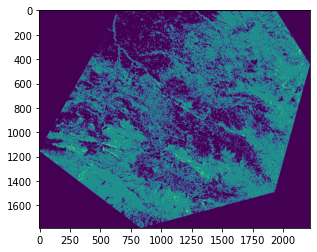

corr_0.025


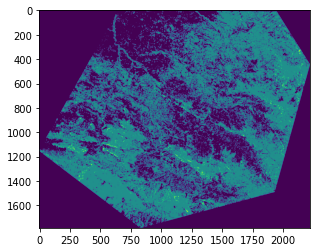

corr_0.05


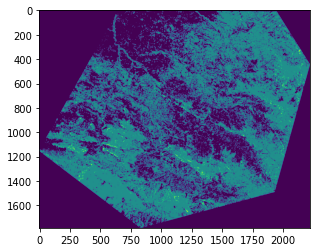

corr_0.1


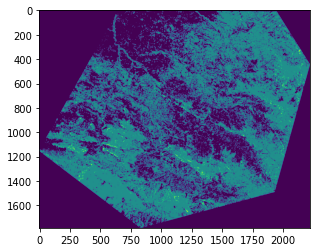

In [23]:
for subs in preds:
    flnme = f'dri_2021_{subs}_new'
    print(subs)
    plt.imshow(rasterio.open(f'output/{flnme}.tif').read(1))
    plt.show(block=False)

# 5. Check they are forest


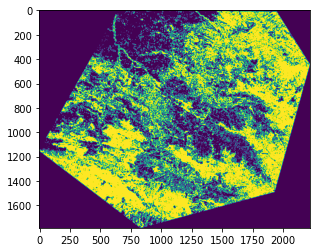

In [27]:
# ensure deforestedd points are forest points in 2020
forest2020 = rasterio.open('intermediate/closed_forest_mask_2020_ds.tif').read(1)
plt.imshow(forest2020)


In [18]:
np.unique(forest2020)

array([0, 1], dtype=int32)

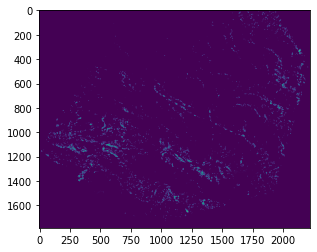

In [17]:
dri_all = rasterio.open('output/dri_2021_corr_0.025_new.tif').read(1)
dri_all = np.where(dri_all<0,0,dri_all)
plt.imshow(dri_all)


In [43]:
dri_all.shape == forest2020.shape

True

In [44]:
dri_forest = dri_all*forest2020

In [45]:
sum(sum(dri_all==dri_forest))==dri_all.shape[0]*dri_all.shape[1]

True

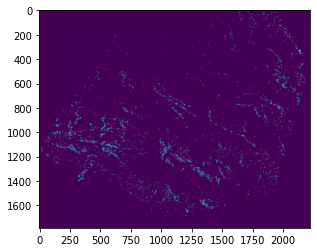

In [46]:
disturbances19=rasterio.open('intermediate/deforestation_2019_ds.tif').read(1)
plt.imshow(disturbances19)


In [47]:
dist_are_fortest = disturbances19*forest2020


In [48]:
sum(sum(dist_are_fortest==disturbances19))/(dist_are_fortest.shape[0]*dist_are_fortest.shape[1])


0.997653809725329

In [49]:
sum(sum(disturbances19>0))/(dist_are_fortest.shape[0]*dist_are_fortest.shape[1])


0.010416792616327107

In [19]:
q,w=np.unique(dri_all, return_counts=True)

In [20]:
q


array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.22, 0.24,
       0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46,
       0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68,
       0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 ,
       0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32)

In [21]:
w

array([3909116,   24538,    2214,     380,      74,      41,      12,
             2,       4,       3,       3,       5,       3,       8,
            12,      15,      22,      23,      34,      54,      39,
            53,      57,      67,      99,     121,     121,     137,
           172,     172,     193,     231,     275,     309,     378,
           399,     490,     511,     630,     684,     745,     724,
           955,    1415,    2424,    4148,    6265,    7156,    4307])

In [22]:
w[1:].sum()/w.sum()

0.015296334361082563

In [ ]:
plt.imshow(rasterio.open('intermediate/predominant_land_use_2017_ds.tif').read(1))


In [31]:
rasterio.open(f'output/{flnme}.tif').bounds

BoundingBox(left=603558.1120000001, bottom=1707794.128, right=647578.1120000001, top=1742194.128)

In [42]:
a=rasterio.open(f'output/{flnme}.tif').read(1)

In [76]:
rasterio.open(f'output/{flnme}.tif').bounds

BoundingBox(left=603558.1120000001, bottom=1707794.128, right=647578.1120000001, top=1742194.128)

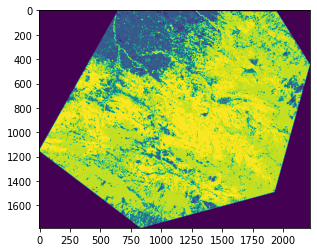

In [45]:
plt.imshow(rasterio.open('intermediate/predominant_land_use_2017_ds.tif').read(1))


In [20]:
b=rasterio.open(f'output/{flnme}.tif').read(1)

In [43]:
a_nozero=np.where(a<0,0,a)

In [44]:
import numpy as np 
np.unique(a_nozero, return_counts=True)

(array([0.        , 0.02      , 0.03333334, 0.04      , 0.06      ,
        0.08      , 0.1       , 0.10666667, 0.12      , 0.13      ,
        0.13666667, 0.14      , 0.14666666, 0.16      , 0.16666667,
        0.17      , 0.17666666, 0.18      , 0.18666667, 0.19      ,
        0.19333333, 0.2       , 0.21      , 0.21666667, 0.22      ,
        0.22666667, 0.24      , 0.24666667, 0.25      , 0.26      ,
        0.26666668, 0.27      , 0.28      , 0.28666666, 0.29      ,
        0.3       , 0.31      , 0.32      , 0.32666665, 0.33      ,
        0.34      , 0.35      , 0.35333332, 0.36      , 0.36666667,
        0.37      , 0.37666667, 0.38      , 0.39      , 0.4       ,
        0.42      , 0.44      , 0.45      , 0.46      , 0.47      ,
        0.48      , 0.5       , 0.52      , 0.53      , 0.54      ,
        0.56      , 0.58      , 0.6       , 0.62      , 0.63      ,
        0.64      , 0.66      , 0.67      , 0.68      , 0.7       ,
        0.72      , 0.74      , 0.75      , 0.76

In [24]:
b=np.where(a<0,0,a)

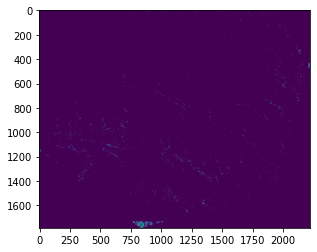

In [46]:
plt.imshow(a_nozero)

In [73]:
1-3753249/(a.shape[0]*a.shape[1])

0.008577232336253071

In [42]:
deforestation_20=rasterio.open('intermediate/deforestation_2020_ds.tif').read(1)

In [43]:
q,w=np.unique(deforestation_20, return_counts=True)

In [44]:
q


array([0., 1.], dtype=float32)

In [59]:
deforestation_20_average=rasterio.open('intermediate/deforestation_2018_ds.tif').read(1)

In [60]:
e,r=np.unique(deforestation_20_average, return_counts=True)

In [61]:
e


array([0., 1.], dtype=float32)

In [57]:
r

array([3755523,   30197])

In [58]:
30197/(3755523+30197)

0.9933566138013377

# 6. Selection
In the end, the correlation 0.025 from the 'output/dri_model_new.joblib' delivered the best looking outputs. This I shared with Catapult.
